In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from matplotlib_venn import venn3_unweighted
from functools import reduce

# Programs: 
DESeq2 = "DESeq2"
Limma = "Limma-voom"

In [10]:
def extract_significant_genes(filename, output_prefix, header, program, p_value_threshold, log2_fc_threshold):
    
    inputfile = open(filename, "r")
    
    upreg_genes = open(output_prefix + "_upregulated.txt", "w")
    downreg_genes = open(output_prefix + "_downregulated.txt", "w")
    all_significant_genes = open(output_prefix + "_all.txt", "w")
    

    for line in inputfile:
        
        # Don't read the first row if its a header row
        if header == True: 
            header = False
            continue
            
        fields = line.split()
        
        if program == DESeq2:
            gene_id = fields[0]
            logFC = fields[2]
            p_val_adj = fields[6]
            
            # Skip line if it doesn't have values
            if logFC == "NA" or p_val_adj == "NA": 
                continue
                
            else: 
                logFC = float(logFC)
                p_val_adj = float(p_val_adj)
        
        if program == Limma:
            gene_id = fields[0]
            logFC = float(fields[1])
            p_val_adj = float(fields[5])
        
        if p_val_adj < p_value_threshold:
            if logFC >= log2_fc_threshold:         
                upreg_genes.write(gene_id + "\n")
                all_significant_genes.write(gene_id + "\n")
            elif logFC <= -log2_fc_threshold: 
                downreg_genes.write(gene_id + "\n")
                all_significant_genes.write(gene_id + "\n")
                
    inputfile.close()
    upreg_genes.close()
    downreg_genes.close()
    all_significant_genes.close()
        

In [3]:
def p_value_list(filename, program):
    
    p_values = []
    inputfile = open(filename, "r")
    
    processed_header = False
    for line in inputfile:
    
        fields = line.strip().split()

        if program == DESeq2:
            p_value = fields[5]
        elif program == Limma: 
            
            # Skip the first line. It's the header line. 
            if processed_header == False:
                processed_header = True
                continue
                
            p_value = fields[4]

        if "NA" in line:
            continue

        p_values.append(float(p_value))
        
    return p_values
    

In [4]:
def p_value_distribution(deseq2, limma_rle, limma_tmm, data_name):

    deseq2_p_values = p_value_list(deseq2, DESeq2)
    limmaRLE_p_values = p_value_list(limma_rle, Limma)
    limmaTMM_p_values = p_value_list(limma_tmm, Limma)        


    fig, axs = plt.subplots(1, 3, sharey=True)

    n_bins = 20
    
    axs[0].hist(deseq2_p_values, bins=n_bins)
    axs[0].set_title("DESeq2")
    axs[1].hist(limmaRLE_p_values, bins=n_bins)
    axs[1].set_title("Limma-voom RLE")
    axs[2].hist(limmaTMM_p_values, bins=n_bins)
    axs[2].set_title("Limma-voom TMM")

    fig = gcf()
    fig.suptitle("P-Value Distribution: " + data_name, fontsize=14)
    plt.show()


In [5]:
def process_GLDS(deseq2, limma_rle, limma_tmm, data_prefix, p_value, log_fc):

    ##############
    ### DESeq2 ###

    prefix = "deseq2_" + data_prefix
    header = False
    extract_significant_genes(deseq2, prefix, header, DESeq2, p_value, log_fc)

    ##############
    ### Limma ###

    # RLE Normalization

    prefix = "limma_rle_" + data_prefix
    header = True
    extract_significant_genes(limma_rle, prefix, header, Limma, p_value, log_fc)

    # TMM Normalization
    
    prefix = "limma_tmm_" + data_prefix
    header = True
    extract_significant_genes(limma_tmm, prefix, header, Limma, p_value, log_fc)

In [6]:
def quantify_results(glds):
    
    # File Names
    all_genes_deseq2 = "deseq2_" + glds + "_all.txt"
    upreg_genes_deseq2 = "deseq2_" + glds + "_upregulated.txt"
    downreg_genes_deseq2 = "deseq2_" + glds + "_downregulated.txt"
    
    all_genes_limmaRLE = "limma_rle_" + glds + "_all.txt"
    upreg_genes_limmaRLE = "limma_rle_" + glds + "_upregulated.txt"
    downreg_genes_limmaRLE = "limma_rle_" + glds + "_downregulated.txt"

    all_genes_limmaTMM = "limma_tmm_" + glds + "_all.txt"
    upreg_genes_limmaTMM = "limma_tmm_" + glds + "_upregulated.txt"
    downreg_genes_limmaTMM = "limma_tmm_" + glds + "_downregulated.txt"    
    
    print "~~~DESeq2 Results~~~"
    print "Number of DE Genes: "
    !wc -l $all_genes_deseq2
    print "Number of Upregulated Genes: "
    !wc -l $upreg_genes_deseq2
    print "Number of Downregulated Genes: "
    !wc -l $downreg_genes_deseq2
    
    print "\n"
    print "~~~Limma-voom with RLE Normalization Results~~~"
    print "Number of DE Genes: "
    !wc -l $all_genes_limmaRLE
    print "Number of Upregulated Genes: "
    !wc -l $upreg_genes_limmaRLE
    print "Number of Downregulated Genes: "
    !wc -l $downreg_genes_limmaRLE
    
    print "\n"
    print "~~~Limma-voom with TMM Normalization Results~~~"
    print "Number of DE Genes: "
    !wc -l $all_genes_limmaTMM
    print "Number of Upregulated Genes: "
    !wc -l $upreg_genes_limmaTMM
    print "Number of Downregulated Genes: "
    !wc -l $downreg_genes_limmaTMM  

In [7]:
def venn_diagram(glds):

    all_deseq2_genes = "deseq2_" + glds + "_all.txt"
    all_genes_limmaRLE = "limma_rle_" + glds + "_all.txt"
    all_genes_limmaTMM = "limma_tmm_" + glds + "_all.txt"

    deseq2_gene_ids = np.genfromtxt(all_deseq2_genes, dtype='str')
    limmaRLE_gene_ids = np.genfromtxt(all_genes_limmaRLE, dtype='str')
    limmaTMM_gene_ids = np.genfromtxt(all_genes_limmaTMM, dtype='str')

    # 3-way Intersection values
    # This is the value at the center of the venn diagram
    deseq2_limmaRLE_limmaTMM = len(reduce(np.intersect1d, (deseq2_gene_ids, limmaRLE_gene_ids, limmaTMM_gene_ids)))

    # 2-way Intersection Values 
    deseq2_limmaRLE = len(np.intersect1d(deseq2_gene_ids, limmaRLE_gene_ids)) - deseq2_limmaRLE_limmaTMM
    deseq2_limmaTMM = len(np.intersect1d(deseq2_gene_ids, limmaTMM_gene_ids)) - deseq2_limmaRLE_limmaTMM
    limmaRLE_limmaTMM = len(np.intersect1d(limmaRLE_gene_ids, limmaTMM_gene_ids)) - deseq2_limmaRLE_limmaTMM

    # Unique values
    deseq2_count = len(deseq2_gene_ids) - deseq2_limmaRLE - deseq2_limmaTMM - deseq2_limmaRLE_limmaTMM
    limmaRLE_count = len(limmaRLE_gene_ids) - deseq2_limmaRLE - limmaRLE_limmaTMM - deseq2_limmaRLE_limmaTMM
    limmaTMM_count = len(limmaTMM_gene_ids) - deseq2_limmaTMM - limmaRLE_limmaTMM - deseq2_limmaRLE_limmaTMM

    plt.title(glds)
    venn3_unweighted(subsets = (deseq2_count, limmaRLE_count, deseq2_limmaRLE, limmaTMM_count, deseq2_limmaTMM, limmaRLE_limmaTMM, deseq2_limmaRLE_limmaTMM),
         set_labels = ('DESeq2', 'Limma-voom RLE', 'Limma-voom TMM'))

    plt.show()

In [8]:
def perform_analysis(p_value, log2fc):

    ###################
    ### Input Files ###
    ###################

    ### GLDS 103 ###
    deseq2_input_glds103 = "../GLDS103/DESeq2/Galaxy84-[DESeq2_result_file_on_data_72,_data_71,_and_others].tabular"
    limma_rle_input_glds103 = "../GLDS103/Limma_RLE/Galaxy87-[limma_on_data_72,_data_71,_and_others__Tables__limma-voom_FLT-GC].tabular"
    limma_tmm_input_glds103 = "../GLDS103/Limma_TMM/Galaxy90-[limma_on_data_72,_data_71,_and_others__Tables__limma-voom_FLT-GC].tabular"

    ### GLDS 104 ###
    deseq2_input_glds104 = "../GLDS104/DESeq2/Galaxy13-[DESeq2_result_file_on_data_12,_data_11,_and_others].tabular"
    limma_rle_input_glds104 = "../GLDS104/Limma_RLE/Galaxy16-[limma_on_data_12,_data_11,_and_others__Tables__limma-voom_FLT-GC].tabular"
    limma_tmm_input_glds104 = "../GLDS104/Limma_TMM/Galaxy19-[limma_on_data_12,_data_11,_and_others__Tables__limma-voom_FLT-GC].tabular"

    ### GLDS 105 ###
    deseq2_input_glds105 = "../GLDS105/DESeq2/Galaxy12-[DESeq2_result_file_on_data_11,_data_10,_and_others].tabular"
    limma_rle_input_glds105 = "../GLDS105/Limma_RLE/Galaxy15-[limma_on_data_11,_data_10,_and_others__Tables__limma-voom_FLT-GC].tabular"
    limma_tmm_input_glds105 = "../GLDS105/Limma_TMM/Galaxy17-[limma_on_data_11,_data_10,_and_others__Tables__limma-voom_FLT-GC].tabular"

    ##################################
    ### P-value Distribution Check ###
    ##################################

    p_value_distribution(deseq2_input_glds103, limma_rle_input_glds103, limma_tmm_input_glds103, "GLDS103")
    p_value_distribution(deseq2_input_glds104, limma_rle_input_glds104, limma_tmm_input_glds104, "GLDS104")
    p_value_distribution(deseq2_input_glds105, limma_rle_input_glds105, limma_tmm_input_glds105, "GLDS105")

    ###################################
    ### P-value and LogFC Filtering ###
    ###################################

    process_GLDS(deseq2_input_glds103, limma_rle_input_glds103, limma_tmm_input_glds103, "glds103", p_value, log2fc)
    process_GLDS(deseq2_input_glds104, limma_rle_input_glds104, limma_tmm_input_glds104, "glds104", p_value, log2fc)
    process_GLDS(deseq2_input_glds105, limma_rle_input_glds105, limma_tmm_input_glds105, "glds105", p_value, log2fc)

    ################################
    ### Print Number of DE Genes ###
    ################################

    print "#### GLDS103 ####"
    quantify_results("glds103")

    print ""
    print "#### GLDS104 ####"
    quantify_results("glds104")

    print ""
    print "#### GLDS105 ####"
    quantify_results("glds105")


    ##############################
    ### Generate Venn Diagrams ###
    ##############################

    venn_diagram("glds103")
    venn_diagram("glds104")
    venn_diagram("glds105")

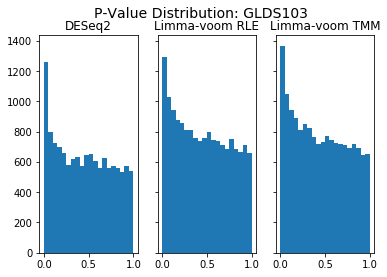

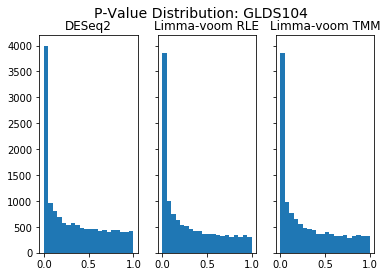

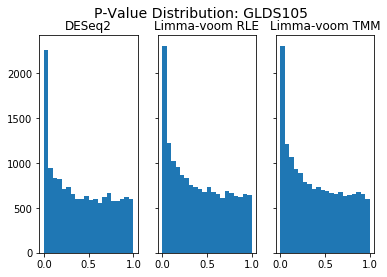

#### GLDS103 ####
~~~DESeq2 Results~~~
Number of DE Genes: 
       5 deseq2_glds103_all.txt
Number of Upregulated Genes: 
       1 deseq2_glds103_upregulated.txt
Number of Downregulated Genes: 
       4 deseq2_glds103_downregulated.txt


~~~Limma-voom with RLE Normalization Results~~~
Number of DE Genes: 
       7 limma_rle_glds103_all.txt
Number of Upregulated Genes: 
       3 limma_rle_glds103_upregulated.txt
Number of Downregulated Genes: 
       4 limma_rle_glds103_downregulated.txt


~~~Limma-voom with TMM Normalization Results~~~
Number of DE Genes: 
       7 limma_tmm_glds103_all.txt
Number of Upregulated Genes: 
       3 limma_tmm_glds103_upregulated.txt
Number of Downregulated Genes: 
       4 limma_tmm_glds103_downregulated.txt

#### GLDS104 ####
~~~DESeq2 Results~~~
Number of DE Genes: 
     108 deseq2_glds104_all.txt
Number of Upregulated Genes: 
      49 deseq2_glds104_upregulated.txt
Number of Downregulated Genes: 
      59 deseq2_glds104_downregulated.txt


~~~Limma-voom

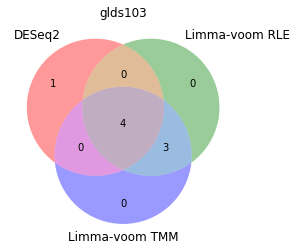

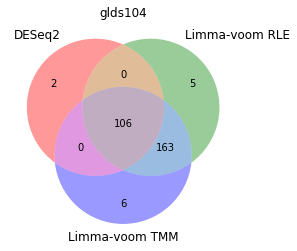

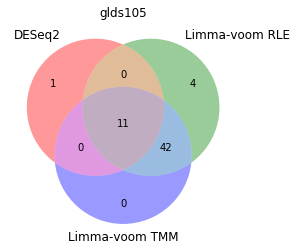

In [11]:
# Driver Code. This executes program above.
P_VALUE = 0.05
LOG2_FC = 1.4

perform_analysis(P_VALUE, LOG2_FC)


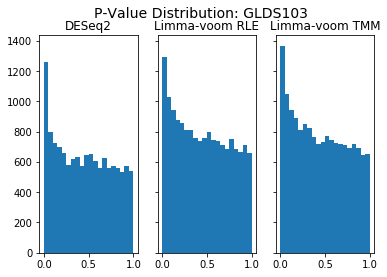

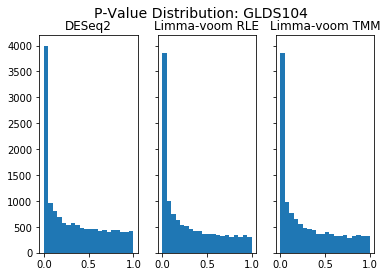

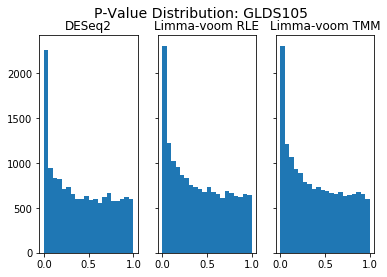

#### GLDS103 ####
~~~DESeq2 Results~~~
Number of DE Genes: 
      60 deseq2_glds103_all.txt
Number of Upregulated Genes: 
      51 deseq2_glds103_upregulated.txt
Number of Downregulated Genes: 
       9 deseq2_glds103_downregulated.txt


~~~Limma-voom with RLE Normalization Results~~~
Number of DE Genes: 
      13 limma_rle_glds103_all.txt
Number of Upregulated Genes: 
       8 limma_rle_glds103_upregulated.txt
Number of Downregulated Genes: 
       5 limma_rle_glds103_downregulated.txt


~~~Limma-voom with TMM Normalization Results~~~
Number of DE Genes: 
      12 limma_tmm_glds103_all.txt
Number of Upregulated Genes: 
       7 limma_tmm_glds103_upregulated.txt
Number of Downregulated Genes: 
       5 limma_tmm_glds103_downregulated.txt

#### GLDS104 ####
~~~DESeq2 Results~~~
Number of DE Genes: 
     811 deseq2_glds104_all.txt
Number of Upregulated Genes: 
     523 deseq2_glds104_upregulated.txt
Number of Downregulated Genes: 
     288 deseq2_glds104_downregulated.txt


~~~Limma-voom

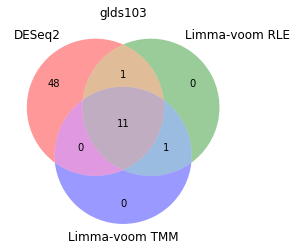

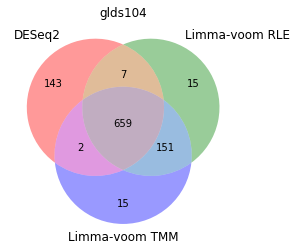

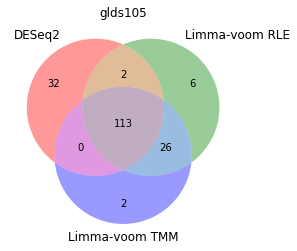

In [12]:
P_VALUE = 0.05
LOG2_FC = 0.75

perform_analysis(P_VALUE, LOG2_FC)